In [13]:
%load_ext autoreload
%autoreload 2
from experiment.experiment import Experiment
from models.tensorflow.monde import Monde
from conf import conf
from models.tensorflow.conf import tf_conf
from experiment.hyper_param_opt import GridSearch
from models.tensorflow.tf_simple_train_eval import TfSimpleTrainEvalModelFactory
from skopt.space import Categorical
from models.tensorflow.utils import get_eval_inputs,get_inputs
from data.data_utils import DataLoader
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.palettes import Category10_5 as colors
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
import pandas as pd
from functools import reduce
from experiment.experiment import InMemoryCollector
from copy import copy
from sklearn.metrics import roc_curve,auc,precision_recall_curve,average_precision_score
from sklearn.ensemble import RandomForestClassifier
import os
from sklearn.utils.fixes import signature
from scipy import stats
from itertools import combinations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
output_notebook()

Loading BokehJS ...

In [15]:
exp = Experiment('classification/fx_3')
conf.num_workers = 1
conf.visible_device_list = [0]
exp.load(model_name="Pumonde2")

In [1]:
exp.data_loader.figure_train();

In [17]:
y_95_percentile = np.percentile(exp.data_loader.train_y, 95,axis=0)

In [2]:
result_test = exp.predict_best_model({'x':exp.data_loader.test_x, 'y':(np.ones(exp.data_loader.test_y.shape)*y_95_percentile).astype(np.float32)}, InMemoryCollector())

In [19]:
cdf = result_test["cdf"]

In [20]:
score = 1-cdf

In [21]:
true_label_test = np.any(exp.data_loader.test_y > y_95_percentile, axis=1)

In [22]:
fpr, tpr, thresholds = roc_curve(true_label_test, score)
roc_auc = auc(fpr, tpr)

<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic, Area=0.95')

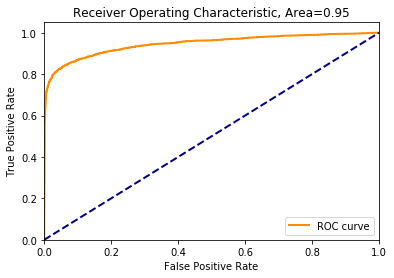

In [23]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Area={0:0.2f}'.format(roc_auc))
plt.legend(loc="lower right")
# plt.show();
plt.savefig('figures/roc_pumonde.png',dpi=1200)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.05)

(0.0, 1.0)

Text(0.5, 1.0, 'Precision-Recall curve, Area=0.87')

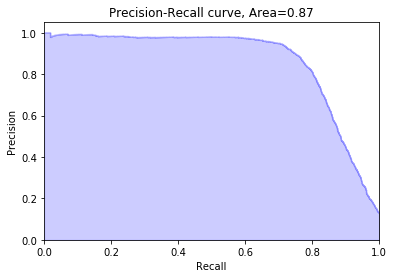

In [24]:
precision, recall, _ = precision_recall_curve(true_label_test, score)
average_precision = average_precision_score(true_label_test, score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve, Area={0:0.2f}'.format(
          average_precision))
# plt.show();
plt.savefig('figures/pr_pumonde.png',dpi=1200)